# Chronic Lymphotic Leukemia dataset

Pacienti s chronickou leukémiou chodia na pravidelné vyšetrenie, bežne raz za mesiac. Choroba sa lieči ale sa nevylieči. Keď je stav zlepšený, tak môžu chodiť v intervale 3 alebo 6 mesiacov. Laboratórne vyšetrenie sa robí odberom, potom testy v laboratoriách, hodnoty sa sumarizujú a posielajú naspäť lekárom. Každé takéto vyšetrenie má rozsiahle výsledky, ktoré sa hodnotia dlho. Nemocnica vedie aj centrálne záznamy o pacientoch (osobné údaje), kontakty s poisťovňou aj ďalšie potrebné údaje.

V záznamoch laboratórnych vyšetrení je závislá premenná (**indikator**) indikujúca stavu choroby pacienta. Ide o indikáciu či patient potrebuje ďalšie laboratórne vyšetrenie v preddefinovanom intervale alebo ten interval sa dá predĺžiť na základe výsledkov laboratorných testov aj osobných údajov pacienta.

Pokiaľ má indikátor nenulovú hodnotu, pacientov stav nie je zlepšený a je nutné ďalšie laboratórne vyšetrenie.

V dátach sú údaje 3060 ľudí. **SSN - social security number** je ich unique ID.



In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import pylab as py
import scipy.stats as stats
import category_encoders as ce

from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC, SVR
from sklearn.feature_selection import RFE
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from statistics import median, mean
from math import inf

## Príprava dát

In [2]:
filename = "data/labor.csv"
labor = pd.read_csv(filename, sep='\t', index_col=0)

filename = "data/profiles.csv"
profiles = pd.read_csv(filename, sep='\t', index_col=0, parse_dates=['birthdate'])

**Tabuľka *labor***
- zmena hodnoty *smoker* z 'N' na 'no' z 'Y' na 'yes'
- premenovanie názvov stĺpcov
- odstraňovanie duplikátov
- úprava null hodnôt pomocou vymazania alebo kNN klasifikácie

In [3]:
labor['smoker'] = np.where(labor['smoker'] == 'N', 'no', labor['smoker'])
labor['smoker'] = np.where(labor['smoker'] == 'Y', 'yes', labor['smoker'])

In [4]:
labor.rename(columns = {'hematokrit':'hematocrit', 'leukocyty':'leukocytes', 'erytrocyty':'erytrocytes', 'trombocyty':'trombocytes'}, inplace = True)

In [5]:
labor.drop_duplicates(inplace=True)

V tomto prípade použijeme náhodné rozhodovanie o tom, či zmažeme riadky s null hodnotami alebo nie pretože všetky atribúty majú rovnaký počet týchto hodnôt. V lepšom scenári by sme mohli rozhodovať napríklad podľa počtu null hodnôt - ak by presahovali viac ako 1% veľkosti datasetu, dopĺňali by sme ich.

In [6]:
attr = set(labor.columns)
before = labor.shape[0]

for a in attr:
    if labor[a].isnull().sum() > 0:
        if random.randint(0,100) < 60:
            labor.dropna(subset=[a], inplace=True)

print("Odstránených bolo %d riadkov" % (before - labor.shape[0]))

Odstránených bolo 149 riadkov


Resetovanie indexu po vymazávaní outlierov a dopĺňanie nezmazaných riadkov obsahujúcich NaN hodnoty pomocou kNN imputer. Atribúty *ssn* a *smoker* (nenumerické atribúty) do kNN nevstupujú a z datasetu sa pred spustením kNN odpoja.

In [7]:
labor = labor.reset_index()
labor.drop('index', axis=1, inplace=True)

In [8]:
ssn = labor['ssn']
smoker = labor['smoker']

In [9]:
cols = labor.columns
index = cols.get_loc("indicator")

y = labor.indicator
colnames_numerics_only = labor.select_dtypes(include=np.number).columns.tolist()
X = labor[colnames_numerics_only]
X = X.drop('indicator', axis=1)

print('Replacing %d values' % np.isnan(X).sum().sum())

imputer = KNNImputer()
labor = pd.DataFrame(imputer.fit_transform(X),columns = X.columns)

labor.insert(loc=0, column='indicator', value=y)


print('NaN values left: %d' % np.isnan(labor).sum().sum())

labor.insert(loc=1, column='ssn', value=ssn)
labor.insert(loc=1, column='smoker', value=smoker)

Replacing 177 values
NaN values left: 0


**Spojenie tabuliek**

Na uľahčenie práce s dátami vytvoríme jednu tabuľku - *data*, ktorá je spojená podľa unikátneho identifikátora *ssn*.

Sú v nej zahrnuté iba relevantné atribúty, ktoré sa v predchádzajúcej fáze osvedčili ako informatívne.

In [10]:
data = labor.merge(profiles, how='left', on='ssn')

include = set(data.columns) - {'birthdate', 'company', 'job', 'name_x', 'name_y', 'address', 'ssn', 'race', 'relationship', 'weight', 'name'}
data = data[list(include)]

____
## Integrácia a čistenie dát
### Kódovanie dát na číselné hodnoty

- *smoker* - hodnota 'no' na 0 a 'yes' na 1
- *sex* - hodnota 'M' na 0 a 'F' na 1
- *blood_group* namapovaný ako 0+, A-, 0-, B+, B-, A+, AB+, AB- = 1, 2, 3, 4, 5, 6, 7, 8


Všetky tieto hodnoty sú nominálne - jednotlivé vlastnosti spolu nesúvisia, a tak je treba použiť OneHotEncoder. Nakoľko však vytvára nové stĺpce, nie je vhodnou voľbou pre kódovanie rozsiahleho *blood_group* atribútu.

In [11]:
ohe = ce.OneHotEncoder(cols=['smoker'])
data = ohe.fit_transform(data)
data.rename(columns = {'smoker_1':'smoker_no', 'smoker_2':'smoker_yes'}, inplace = True)

ohe = ce.OneHotEncoder(cols=['sex'])
data = ohe.fit_transform(data)
data.rename(columns = {'sex_1':'male', 'sex_2':'female'},  inplace = True)

In [12]:
ce_ordinal_blood = ce.OrdinalEncoder(cols=['blood_group'])
data = ce_ordinal_blood.fit_transform(data)

____
### Outlier detection


Na identifikovanie a upravovanie outlierov použijeme interquartile range metódu. Pokiaľ je počet outlierov nižší ako 1% datasetu, zmažú sa. V opačnom prípade sa ich hodnoty upravujú.

In [13]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [14]:
def delete_or_keep_outliers(n):
    if n < len(data) * 0.01:
        print("Delete outliers")
    else:
        print("Keep outliers")

In [15]:
def change_outliers(a):
    lower = data[a].quantile(0.25) - 1.5 * stats.iqr(data[a])
    upper = data[a].quantile(0.75) + 1.5 * stats.iqr(data[a])
        
    return np.where(data[a] > upper, upper, np.where(data[a] < lower, lower, data[a]))

**Alp**

In [16]:
out = identify_outliers(data.alp)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 478
Keep outliers


In [17]:
data['alp'] = change_outliers('alp')

**Alt**

In [18]:
out = identify_outliers(data.alt)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 988
Keep outliers


In [19]:
data['alt'] = change_outliers('alt')

**Ast**

In [20]:
out = identify_outliers(data.ast)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 76
Delete outliers


In [21]:
data = data.drop(out.index)

**Etytr**

In [22]:
out = identify_outliers(data.etytr)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 75
Delete outliers


In [23]:
data = data.drop(out.index)

**Er-cv**

In [24]:
out = identify_outliers(data['er-cv'])
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 80
Delete outliers


In [25]:
data = data.drop(out.index)

**Erytrocytes**

In [26]:
out = identify_outliers(data.erytrocytes)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 13
Delete outliers


In [27]:
data = data.drop(out.index)

**Hbver**

In [28]:
out = identify_outliers(data.hbver)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 78
Delete outliers


In [29]:
data = data.drop(out.index)

**Hematocrit**

In [30]:
out = identify_outliers(data.hematocrit)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 14
Delete outliers


In [31]:
data = data.drop(out.index)

**Hemoglobin**

In [32]:
out = identify_outliers(data.hemoglobin)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 73
Delete outliers


In [33]:
data = data.drop(out.index)

**Leukocytes**

In [34]:
out = identify_outliers(data.leukocytes)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 6
Delete outliers


In [35]:
data = data.drop(out.index)

**Trombocytes**

In [36]:
out = identify_outliers(data.trombocytes)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 49
Delete outliers


In [37]:
data = data.drop(out.index)

Zresetovanie indexov po všetkých mazaniach hodnôt.

In [38]:
data = data.reset_index()
data.drop('index', axis=1, inplace=True)

data.shape

(9327, 17)

Skopírovanie dataframe pre posledný bod pre zachovanie dát

In [39]:
y = data.indicator
X = data.drop('indicator', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7461, 16) (1866, 16) (7461,) (1866,)


Výber atribútov vhodných na škálovanie a transformáciu:

In [40]:
scaling_attr = set(X_train.columns) - {'smoker_no', 'smoker_yes', 'male', 'female', 'indicator'}
scaling_attr = list(scaling_attr)

In [41]:
pow_attr = scaling_attr.copy()
pow_attr.remove('blood_group')

Definovanie vlastných tried s funkciami na úpravu dát:

In [42]:
class PowerTransformator(TransformerMixin):
    def __init__(self, attr):
        self.attr = attr

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
#         data_train = X
#         data_test = self.Xtestor
        data_train = X[0]
        data_test = X[1]
        
        for a in self.attr:
            #train
            transformer = PowerTransformer(method='yeo-johnson',  standardize=False)
            column = data_train[a].values
            column = column.reshape((len(column),1))
#             col_trans = transformer.fit_transform(column)
            col_trans = transformer.fit(column)
            trans_data = col_trans.transform(column)
            data_train = data_train.drop(a, axis=1)
            data_train.insert(loc=0, column=a, value=trans_data) 
            #test
            column = data_test[a].values
            column = column.reshape((len(column),1))
#             col_trans = transformer.fit_transform(column)
            trans_data = col_trans.transform(column)
            data_test = data_test.drop(a, axis=1)
            data_test.insert(loc=0, column=a, value=trans_data) 
        
        return data_train, data_test

In [43]:
class MinMaxTransforator(TransformerMixin):
    def __init__(self, attr):
        self.attr = attr

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        data_train = X[0]
        data_test = X[1]
        
        for a in self.attr:
            #train
            scaler = MinMaxScaler()
            column = data_train[a].values
            column = column.reshape((len(column),1))
#             col_trans = scaler.fit_transform(column)
            col_trans = scaler.fit(column)
            trans_data = col_trans.transform(column)
            data_train = data_train.drop(a, axis=1)
            data_train.insert(loc=0, column=a, value=trans_data) 
            #test
            column = data_test[a].values
            column = column.reshape((len(column),1))
#             col_trans = scaler.fit_transform(column)
            trans_data = col_trans.transform(column)
            data_test = data_test.drop(a, axis=1)
            data_test.insert(loc=0, column=a, value=trans_data) 
        
        return data_train, data_test

Feature selection pomocou zjednotenia výstupu L1 a Recursive Feature Elimination:

In [44]:
class FeatureSelector(TransformerMixin):
    def __init__(self, yor):
        self.yee = yor
        pass

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, Xor, **transform_params):
        X = Xor[0]
        
        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, self.yee)
        selector = SelectFromModel(estimator=lsvc, prefit=True)
        X_new = selector.transform(X)
        selected_feat = X.columns[(selector.get_support())]
        
        X = Xor[0]
        
        estimator = SVR(kernel="linear")
        selector = RFE(estimator, n_features_to_select=5, step=1)
        selector = selector.fit(X, self.yee)
        selected2 = selector.support_
        
        attrs_to_keep = list(selected_feat)
        for (a, b) in zip(Xor[0].columns, selector.support_):
            if b==True and a not in attrs_to_keep:
                attrs_to_keep.append(a)
            
        data_train = Xor[0]
        data_test = Xor[1]
            
        return data_train[attrs_to_keep], data_test[attrs_to_keep]

Definovanie Pipeline a úprava dát:

In [73]:
ppline = Pipeline([
    ("powerTransformer", PowerTransformator(pow_attr)),
    ("minMaxScaler", MinMaxTransforator(scaling_attr)),
    ("featureSelector", FeatureSelector(y_train))
])

In [74]:
X_train_data, X_test_data = ppline.fit_transform((X_train, X_test), y_train)

In [75]:
X_train_data

,blood_group,hematocrit,erytrocytes,trombocytes,leukocytes,alt
2177,0.857143,0.829623,0.178332,0.409296,0.417235,0.482832
52,1.000000,0.624977,0.734695,0.334675,0.530605,1.000000
4806,0.428571,0.645046,0.359640,0.623137,0.411227,0.384641
3265,0.857143,0.618059,0.269793,0.605965,0.442073,0.481941
1022,0.714286,0.521822,0.334029,0.308170,0.427271,0.486862
...,...,...,...,...,...,...
7576,0.142857,0.624215,0.422427,0.470657,0.178068,0.615934
6037,0.714286,0.931766,0.226569,0.408578,0.429731,0.623155
6027,0.428571,0.498032,0.419629,0.235987,0.298639,0.640844
9013,0.571429,0.534354,0.538584,0.533170,0.717515,0.694810


In [76]:
X_test_data

,blood_group,hematocrit,erytrocytes,trombocytes,leukocytes,alt
1687,0.857143,0.704270,0.582759,0.443786,0.851601,0.770651
3809,0.571429,0.818487,0.636426,0.409042,0.783397,0.916859
7186,0.285714,0.476508,0.428885,0.678824,0.677433,0.569158
7116,0.571429,0.886838,0.188581,0.668448,0.714439,0.233341
3158,0.571429,0.520870,0.381801,0.358200,0.287234,0.387280
...,...,...,...,...,...,...
7412,0.000000,0.335310,0.439185,0.686620,0.412405,0.603686
7674,0.857143,0.409481,0.703581,0.006302,0.416998,1.000000
1812,0.857143,0.482279,0.725448,0.158780,0.493749,1.000000
2881,0.285714,0.881554,0.098911,0.401300,0.506156,0.591305


Pipelines boli doplnené aj o testovaciu množinu dát, ktorá nám chýbala v 2. fáze. 
(Všetka funkcionalita je nepekne riešená cez metódu transform v triedach, pretože fit ma nemá rád)

## Vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu
### 1R algoritmus
Naimplementujte 1R algorithm (1R or OneR), ktorý je jednoduchá klasifikácia t.j. rozhodnutie na základe jedného atribútu. Môžete implementovať komplikovanejšie t.j. zahŕňajúce viacero atribútov (ich kombinácie).
- Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach.
- Vyhodnoťte klasifikátor pomocou metrík accuracy, precision a recall.

In [49]:
def fit(X_data, y_data):
    rules = {
        "column"       : '',
        "breakingPoint": 0.0,
        "left"         : 5,
        "right"        : 5,
        "bestScore"    : 0.0,
    }
    
    y_indic = y_data.reset_index()
    y_indic.drop('index', axis=1, inplace=True)
    y_indic = y_indic['indicator'].values
 
    Indic1 = []
    Indic0 = []
    
    for a in X_data.columns:
        column = X_data[a].values
        for count, value in enumerate(column):
            if  y_indic[count] == 1:
                Indic1.append(value)
            else:
                Indic0.append(value)
        breakingpoint = (median(Indic1) + median(Indic0)) /2      #manualne pravidlo
        Indic1.clear()
        Indic0.clear()
        
        NemaRako = 0
        MaRako = 0
        
        for count, value in enumerate(column):
            if value <= breakingpoint:
                if  y_indic[count] == 1:
                    NemaRako = NemaRako + 1
            else:
                if  y_indic[count] == 0:
                    MaRako = MaRako + 1
            
        uspesnost = float(NemaRako + MaRako) / len(column)
        if (uspesnost < 0.50):
            flipnutaUspesnost = 1 - uspesnost
            if (flipnutaUspesnost > rules['bestScore']):
                rules['bestScore'] = flipnutaUspesnost
                rules['column'] = a
                rules['breakingPoint'] = breakingpoint
                rules['left'] = 0
                rules['right'] = 1
                
        else:
            if (uspesnost > rules['bestScore']):
                rules['bestScore'] = uspesnost
                rules['column'] = a
                rules['breakingPoint'] = breakingpoint
                rules['left'] = 1
                rules['right'] = 0
            
    return rules

Manuálne pravidlo pre výber rozdeľovacieho bodu je veľmi jednoduché. Najskôr sme skúsili priemer z množín indikátorov a tieto dve čísla spriemerovať ale súčasne používané pravidlo dosahuje o niečo lepšie výsledky. Takže sme to nakoniec zmenili na mediány z množín indikátorov a následne vypočítali ich priemer. Existujú aj lepšie metódy pre výber tohto bodu ako bucketing, ale na to nebol čas :D.

Kedže vyberáme hodnoty postupne a overujeme či sú väčšie alebo menšie ako rozdeľovací bod tak preusporiadanie množiny vzostupne nebolo potrebné.

Ak máme úspešnosť nižšiu ako 50% môžeme vymeniť pravidlá na ktorej strane bude aký indikátor a vypočítať doplnok k úspešnosti, pretože tieto množiny sú navzájom doplnky.

In [50]:
def testModel(X_data, y_data, rules):
    y_predicted = []
    
    y_indic = y_data.reset_index()
    y_indic.drop('index', axis=1, inplace=True)
    y_indic = y_indic['indicator'].values
    
    X_test = column = X_data[rules['column']].values
    
    for value in X_test:
        if value <= rules['breakingPoint']:
            y_predicted.append(rules['left'])
        else:
            y_predicted.append(rules['right'])
          
    print('Accuracy score: ', accuracy_score(y_indic, y_predicted))
    print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_indic, y_predicted))
    print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_indic, y_predicted))
        
    return

In [801]:
model = fit(X_train_data, y_train)

In [802]:
model

{'column': 'trombocytes',
 'breakingPoint': 0.4076902582311981,
 'left': 0,
 'right': 1,
 'bestScore': 0.8038128718226069}

In [796]:
testModel(X_test_data, y_test, model)

Accuracy score:  0.807027027027027
Precision score (proportion of positive identifications that is actually correct) 0.8774774774774775
Recall score (proportion of actual positives that is identified correctly) 0.8150627615062761


Z vybraných atribútov sa všetky pohybovali v rozmedzí cca 50 až 65% až na trombocyty, ktoré vo výbere atribútov dosahovali omnoho vyššie skóre ako ostatné atribúty. Takže ako najinformatívnejší atribút dosiahol skóre 80.71%. Na testovacej množine to je 80,7%. Môžme tvrdiť, že pri takýchto číslach a takto jednoduchom modeli nenastáva overfit.

## Natrénovanie a vyhodnotenie klasifikátora strojového učenia
Na trénovanie využite minimálne jeden stromový algoritm strojového učenia v scikit-learn.
- Vizualizujte natrénované pravidlá.
- Vyhodnoťte natrénovaný model pomocou metrík accuracy, precision a recall
- Porovnajte natrénovaný klasifikátor s Vašimi manuálne vytvorenými pravidlami z prvého kroku.

In [805]:
plt.rcParams['figure.figsize'] = 15, 10

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    print(cm)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    return

**Algoritmus DecisionTree**

In [807]:
model = DecisionTreeClassifier().fit(X_train_data, y_train)
y_predicted = model.predict(X_test_data)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))

Training accuracy:  1.0
Test Accuracy:  0.9156756756756756


In [813]:
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Precision score (proportion of positive identifications that is actually correct) 0.9361880772460117
Recall score (proportion of actual positives that is identified correctly) 0.9330543933054394


In [808]:
results = []
estimators = []
for i in range(1, X_train_data.shape[1] + 1):  
    row = {'model_complexity': i}
    
    # Vytvoríme rozhodovací strom
    # strom s maximalnou hlbkou 1-pocet atributov,  simulujeme tak zlozitost modelu
    clf = DecisionTreeClassifier(max_depth = i) 
    
    # natrenovanie modelu a predikovanie na trenovacej sade
    pred = clf.fit(X_train_data, y_train).predict(X_train_data) 
    
    # chyba na trenovacej sade
    row['train'] = 1-accuracy_score(y_train, pred) 
    
    # predickcia
    pred = clf.predict(X_test_data)
    
    # chyba na testovacej sade
    row['test'] = 1-accuracy_score(y_test, pred) 
    results.append(row)
    estimators.append(clf)

In [809]:
complexity_df = pd.DataFrame(results)
complexity_df.head()

,model_complexity,train,test
0,1,0.173337,0.176757
1,2,0.155354,0.162703
2,3,0.142374,0.144865
3,4,0.085857,0.087027
4,5,0.062737,0.065405


<AxesSubplot:xlabel='model_complexity'>

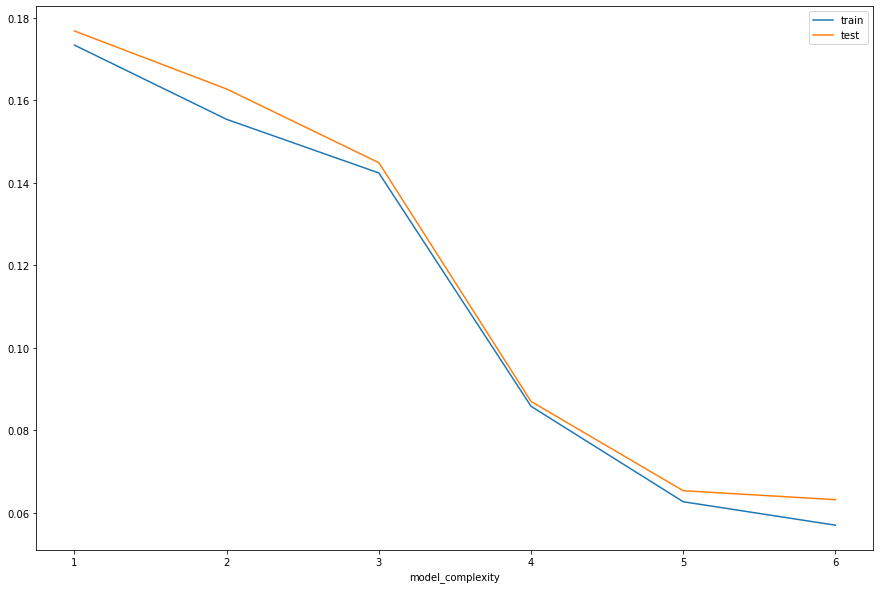

In [810]:
complexity_df.plot(x='model_complexity')

[[ 579   76]
 [  80 1115]]


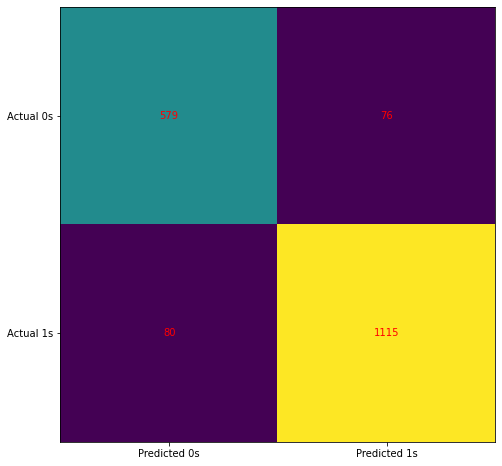

In [811]:
plot_confusion_matrix(y_test, y_predicted)

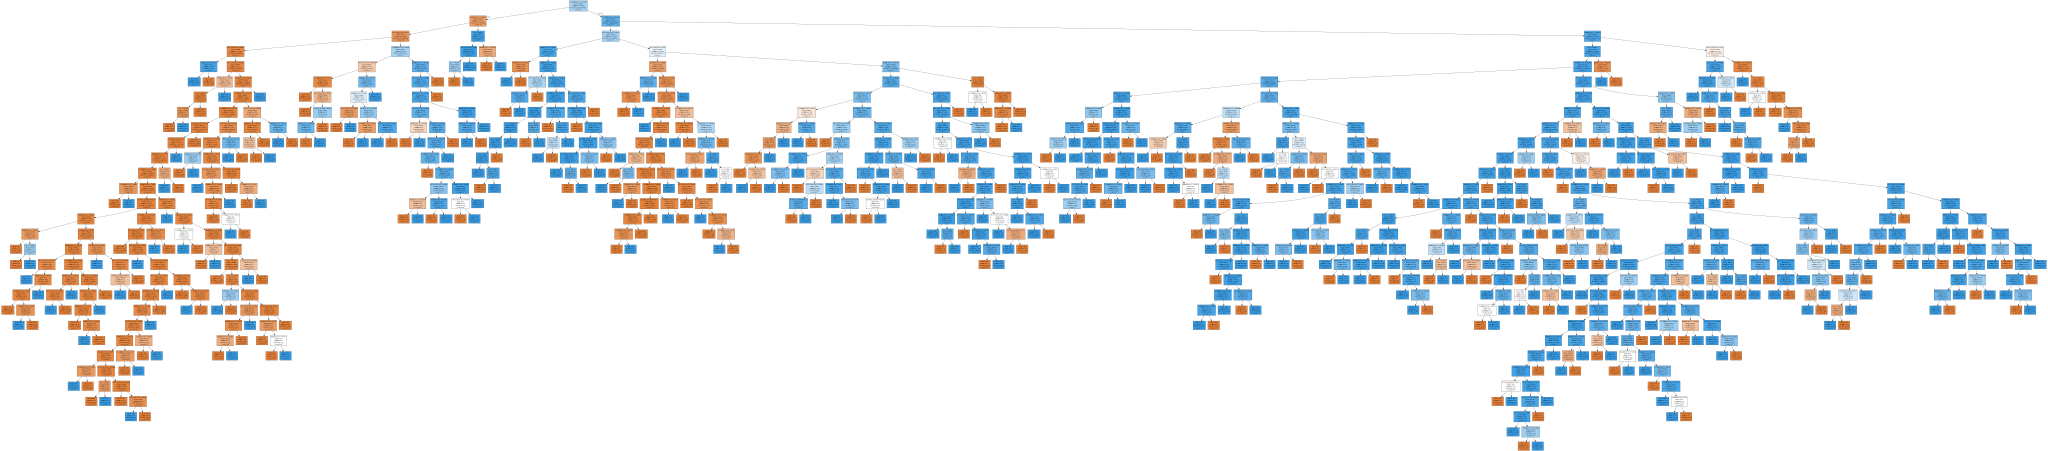

In [812]:
graph = Source(export_graphviz(model, 
                               out_file=None,
                               feature_names=X_train_data.columns,
                               class_names=['0', '1'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

Na základe test score by sa dalo povedať, že model overfituje ale ťažko povedať, kedže chybovosť s model complexity klesá aj train aj test. Zároveň chybovosť pri train sa drží pod úrovňou chybovosti train čo je dobre. Avšak bolo by dobré použiť hyperparametre pre odstránenie možného overfitu

**Algoritmus RandomForest**

In [824]:
model = RandomForestClassifier().fit(X_train_data, y_train)
y_predicted = model.predict(X_test_data)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))

Training accuracy:  0.9998647917793402
Test Accuracy:  0.9551351351351351


In [825]:
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Precision score (proportion of positive identifications that is actually correct) 0.9455128205128205
Recall score (proportion of actual positives that is identified correctly) 0.9874476987447699


In [835]:
results = []
estimators = []
for i in range(1, X_train_data.shape[1] + 1):  
    row = {'model_complexity': i}
    
    # Vytvoríme rozhodovací strom
    # strom s maximalnou hlbkou 1-pocet atributov,  simulujeme tak zlozitost modelu
    clf = RandomForestClassifier(max_depth = i) 
    
    # natrenovanie modelu a predikovanie na trenovacej sade
    pred = clf.fit(X_train_data, y_train).predict(X_train_data) 
    
    # chyba na trenovacej sade
    row['train'] = 1-accuracy_score(y_train, pred) 
    
    # predickcia
    pred = clf.predict(X_test_data)
    
    # chyba na testovacej sade
    row['test'] = 1-accuracy_score(y_test, pred) 
    results.append(row)
    estimators.append(clf)

In [836]:
complexity_df = pd.DataFrame(results)
complexity_df.head()

,model_complexity,train,test
0,1,0.172526,0.179459
1,2,0.152109,0.160541
2,3,0.112764,0.118378
3,4,0.081395,0.085405
4,5,0.063142,0.068108


<AxesSubplot:xlabel='model_complexity'>

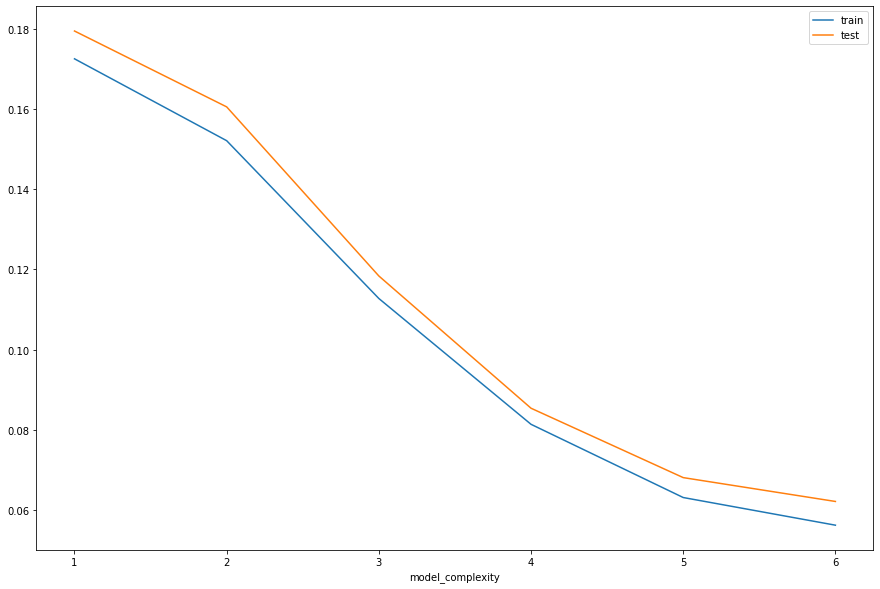

In [837]:
complexity_df.plot(x='model_complexity')

[[ 587   68]
 [  15 1180]]


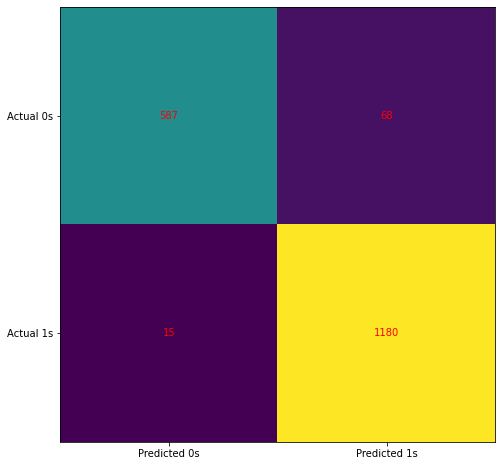

In [838]:
plot_confusion_matrix(y_test, y_predicted)

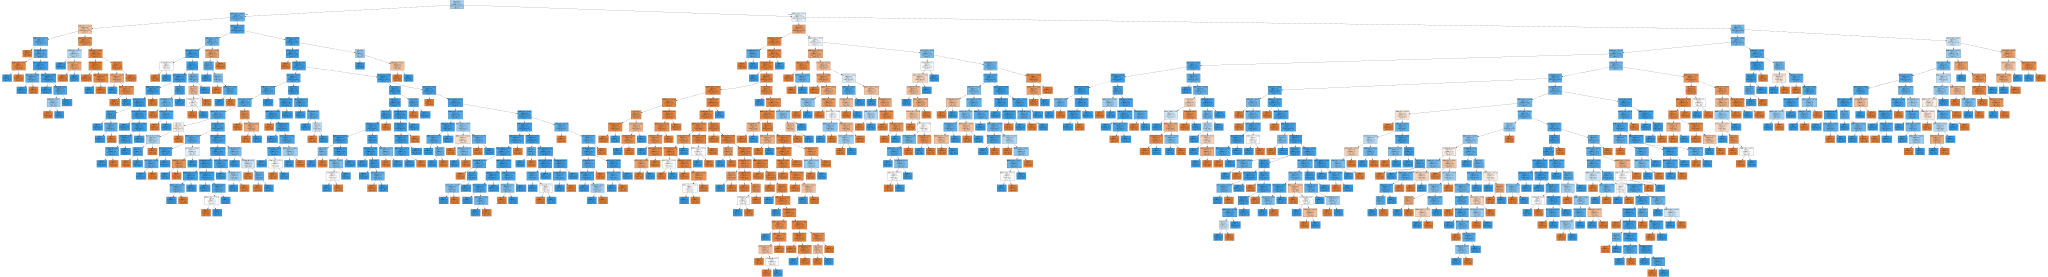

In [843]:
graph = Source(export_graphviz(model.estimators_[0], 
                               out_file=None,
                               feature_names=X_train_data.columns,
                               class_names=['0', '1'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

Aj keď train score je takmer 100% a niekedy aj dosiahne hodnotu 100% tak overfit by nemal byť problémom, pretože je to ensemble learning metóda, ktorá sa mu vyhýba. Zároveň nie je potreba optimalizácia pomocou pruning. Chybovosť s komplexitou modela klesá presne tak ako by mala. Vo všeobecnosti dosahuje lepšie skóre ako predošlý DecisionTree. 

**Algoritmus LogisticRegression**

In [861]:
model = LogisticRegression()
model.fit(X_train_data, y_train)

# Evaluate the model
print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))
y_predicted = model.predict(X_test_data)

Training accuracy:  0.846268253109789
Test Accuracy:  0.8345945945945946


In [862]:
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Precision score (proportion of positive identifications that is actually correct) 0.8541832669322709
Recall score (proportion of actual positives that is identified correctly) 0.897071129707113


[[ 472  183]
 [ 123 1072]]


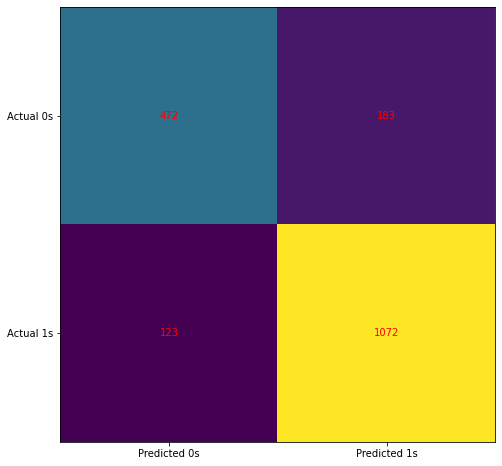

In [870]:
plot_confusion_matrix(y_test, y_predicted)

Je vidieť že logistická regresia je menej presná ako rozhodovacie stromy. Avšak podľa čísel tu nenastavá žiaden možný overfit. Aj keď testovacie skóre je cca 83% tak precision je 85% a recall skoro 90% čo sú metriky viac využiteľné v praxi, takže samotný model nie je až taký zlý nakoniec

-----------------
V závere sú všetky tri modely lepšie ako vlastnoručne implementovaný OneR algoritmus. 

Aj keď presnosť logistickej regresie a OneR je lepšia iba o približne 5%. Dá sa teda povedať, že pre regresný model
nemá pridávanie ďalších atribútov až takú významnú váhu ako najinformatívnejší atribút trombocyty, podľa ktorého je aj model
iba s týmto jedným atribútom celkom presný na 80%.

Vyššie percentá dosahujú rozhodovacie stromy pomocou information gain metrík a rozhodovania sa, kedy pár ďalších atribútov
vie zavážiť.

## Optimalizácia - hyperparameter tuning
Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok. 

Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

**Algoritmus DecisionTree**

In [480]:
param_grid = {
    "max_depth":[5, 10, 20, 30, 40],
    "max_features":[2,3,4,5,6],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 5, 10, 15],
    'criterion': ["gini", "entropy"]
}

model = DecisionTreeClassifier()
#random_state=42
model_tuned = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=10,
                            n_jobs=-1,
                            verbose=2)

model_tuned.fit(X_train_data, y_train)

Fitting 10 folds for each of 1250 candidates, totalling 12500 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 30, 40],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 5, 10, 15],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             verbose=2)

In [481]:
model_tuned.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=5,
                       min_samples_leaf=5, min_samples_split=15)

In [885]:
# model = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=5, min_samples_leaf=10, min_samples_split=15).fit(X_train_data, y_train)
model = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=5,
                       min_samples_leaf=5, min_samples_split=15).fit(X_train_data, y_train)
y_predicted = model.predict(X_test_data)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))

Training accuracy:  0.9548404542996214
Test Accuracy:  0.9432432432432433


In [886]:
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Precision score (proportion of positive identifications that is actually correct) 0.9395161290322581
Recall score (proportion of actual positives that is identified correctly) 0.9748953974895398


Testovacie skóre sa zlepšilo z 87,14% na 94,32% čo je viac ako 7% zlepšenie. Zároveň sme odstránili možný overfit keďže trénovacie skóre v pôvodnom DecisionTree bolo 100% a tu sa znížilo na 95,48%. Zároveň je trénovacie skóre o niečo vyššie ako testovacie takže by nemal byť skrytý problém s dátami a model by mal fungovať správne.

<AxesSubplot:xlabel='model_complexity'>

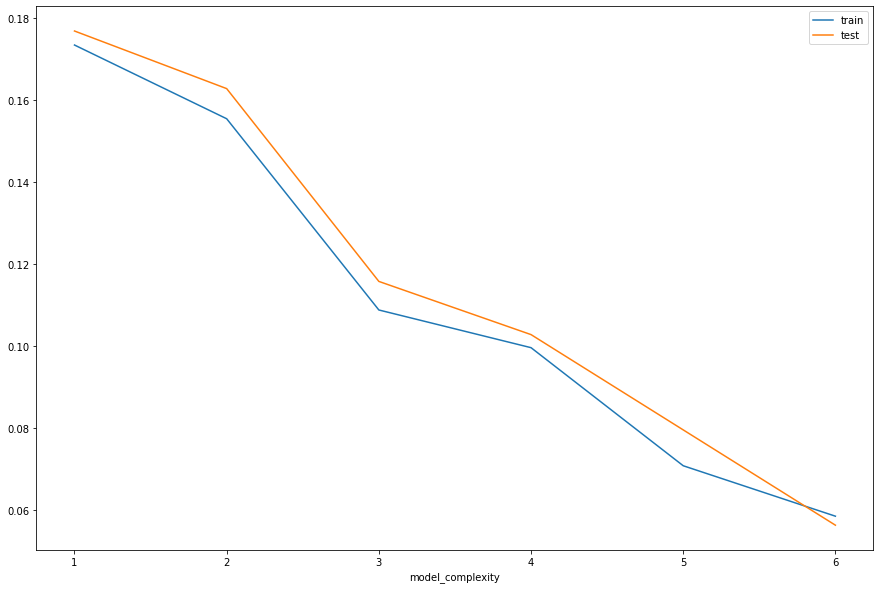

In [889]:
results = []
estimators = []
for i in range(1, X_train_data.shape[1] + 1):  
    row = {'model_complexity': i}
    
    # Vytvoríme rozhodovací strom
    # strom s maximalnou hlbkou 1-pocet atributov,  simulujeme tak zlozitost modelu
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=i, max_features=5,
                       min_samples_leaf=5, min_samples_split=15).fit(X_train_data, y_train)
    
    # natrenovanie modelu a predikovanie na trenovacej sade
    pred = clf.fit(X_train_data, y_train).predict(X_train_data) 
    
    # chyba na trenovacej sade
    row['train'] = 1-accuracy_score(y_train, pred) 
    
    # predickcia
    pred = clf.predict(X_test_data)
    
    # chyba na testovacej sade
    row['test'] = 1-accuracy_score(y_test, pred) 
    results.append(row)
    estimators.append(clf)
    
complexity_df = pd.DataFrame(results)
complexity_df.plot(x='model_complexity')

Je vidieť, že pri 6 parametroch nastavá overfit. Avšak najlepší model má zadefinované max_features=5 kedy je model najviac konzistentný.

Gini a Entropy sú spôsoby ako rátať kritérium pre optimálnu hodnotu rozdelenia vetiev stromu. 

Max depth je maximálna hĺbka stromu od koreňu po list. Nastavovaním maxima sa vyhneme overfitu.

Max features je maximálny počet atribútov pre model. Pri moc veľkom množstve môže nastať overfit.

Min samples split je minimálny počet pozorovaní v uzle predtým ako sa rozdelí. Základné číslo je 2 avšak navýšenie môže mať za následok eliminovanie overfitu.

Min_samples_leaf udáva minimálny počet pozorovaní, ktoré sa budú nachádzať v listoch po tom ako sa uzol rozdelí. Zvýšenie tejto hodnoty môže mať za následok elimináciu overfitu.

**Algoritmus RandomForest**

Zbehnutie trvalo cca 40 minút.

In [525]:
param_grid = {
#     "n_estimators":[100, 200, 300, 400, 500],
    "n_estimators":[100, 200, 300],
    "max_depth":[30, 40, 50, 60],
    "max_features":[3,4,5,6],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
#     'bootstrap': [True, False],
}

model = RandomForestClassifier()

model_tuned = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=5,
                            n_jobs=-1,
                            verbose=2)

model_tuned.fit(X_train_data, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [30, 40, 50, 60],
                         'max_features': [3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [526]:
model_tuned.best_estimator_

RandomForestClassifier(max_depth=50, max_features=4, min_samples_leaf=2,
                       min_samples_split=5)

In [574]:
model = RandomForestClassifier(max_depth=50, max_features=4, min_samples_leaf=2,
                       min_samples_split=5).fit(X_train_data, y_train)
    # toto by malo byt aktualne akurat ↑
# model = RandomForestClassifier(max_depth=30, max_features=5, min_samples_split=5, n_estimators=200).fit(X_train_data, y_train)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))

Training accuracy:  0.9760681449432126
Test Accuracy:  0.9567567567567568


Maximálne testovacie skóre bolo dostiahnuté 95.93%. Avšak vtedy bolo trénovacie skóre 100%. Pokiaľ sa dá hovoriť o overfite tak súčasný model vyzerá lepšie. Znížilo sa trénovacie skóre z takmer 100% na 97,6%. Testovacie skóre sa nepatrne zvýšilo o 95,51% na 95,67%. Vo všeobecnosti hyperparametre moc nepomohli pre lepšiu výkonnosť modelu avšak dosiahli sme odstránenie potenciálneho overfitu.

<AxesSubplot:xlabel='model_complexity'>

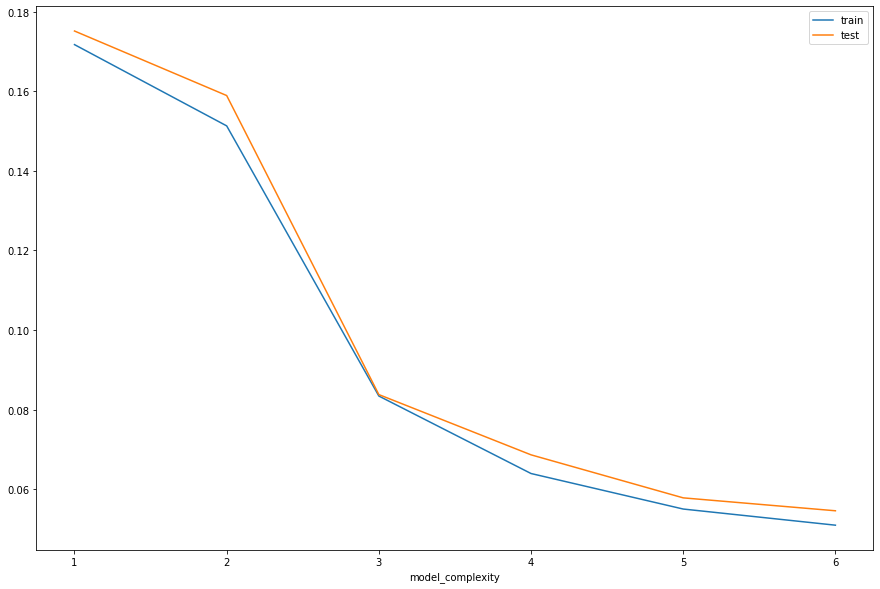

In [905]:
results = []
estimators = []
for i in range(1, X_train_data.shape[1] + 1):  
    row = {'model_complexity': i}
    
    # Vytvoríme rozhodovací strom
    # strom s maximalnou hlbkou 1-pocet atributov,  simulujeme tak zlozitost modelu
    clf = RandomForestClassifier(max_depth=i, max_features=4, min_samples_leaf=2, min_samples_split=5)
    
    # natrenovanie modelu a predikovanie na trenovacej sade
    pred = clf.fit(X_train_data, y_train).predict(X_train_data) 
    
    # chyba na trenovacej sade
    row['train'] = 1-accuracy_score(y_train, pred) 
    
    # predickcia
    pred = clf.predict(X_test_data)
    
    # chyba na testovacej sade
    row['test'] = 1-accuracy_score(y_test, pred) 
    results.append(row)
    estimators.append(clf)
    
complexity_df = pd.DataFrame(results)
complexity_df.plot(x='model_complexity')

Chyba s pridanými atribútmi klesá, takže overfit by nemal byť problém. Chyba sa nemení z 5 na 6 atribútov. Toto bolo nájdené vo väčšine pokusou pomocou hyperparametrov, kedy max_features=5. V poslednom finálnom spustení však našlo najoptimálnejší model s max_features = 5. Každopádne vieme povedať že 6 ich nebude. Avšak celkové skóre modelu stúplo iba nepatrne o pár stotín, v niektorých prípadoch o pár desatích percent. Toto je spôsobené faktom, že RandomForest už má v sebe implementované potrebné metriky pre vybratie ideálneho algoritmu a ideálnych atribútov.

N_estimators je počet stromov v lese, pre ktoré hľadá algoritmus riešenie. Vo väčšine prípadov to bolo číslo 200, avšak v poslednom pokuse nie je zobrazený tento parameter pretože je tam default, ktorý je 100.

Bootstrap je spôsob vzorkovania s náhodným nahrádzanám ak je True. Vo všetkých pokusov to však bolo nastavené na True, čo je default hodnota preto sme to nakoniec neuvádzali ako hyperparameter, pretože to iba zväčšovali zložitosť algoritmu. Po odstránení tohto hyperparametru sme si mohli dovoliť zdvihnúť počet skupín v cross validation z 3 na 5.

**Algoritmus LogisticRegression**

In [600]:
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'penalty': ['none', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
}

model = LogisticRegression(random_state=42)

model_tuned = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=10,
                            n_jobs=-1,
                            verbose=2)

model_tuned.fit(X_train_data, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=2)

In [601]:
model_tuned.best_estimator_

LogisticRegression(C=10, random_state=42, solver='newton-cg')

In [622]:
param_grid = {
    'solver': ['saga'],
    'penalty': ['elasticnet'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'l1_ratio': list(np.arange(0.0,1.0,0.1))
}

model = LogisticRegression(random_state=42)

model_tuned = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=10,
                            n_jobs=-1,
                            verbose=2)

model_tuned.fit(X_train_data, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                      0.5, 0.6000000000000001,
                                      0.7000000000000001, 0.8, 0.9],
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             verbose=2)

In [623]:
model_tuned.best_estimator_

LogisticRegression(C=10, l1_ratio=0.0, penalty='elasticnet', random_state=42,
                   solver='saga')

In [625]:
model = LogisticRegression(C=10, random_state=42, penalty='l2', solver='newton-cg').fit(X_train_data, y_train)
# model = LogisticRegression(C=10, l1_ratio=0.0, penalty='elasticnet', random_state=42, solver='saga').fit(X_train_data, y_train)

# Evaluate the model
print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))

Training accuracy:  0.8478907517577069
Test Accuracy:  0.8367567567567568


Penalty je by default nastavená na l2. l1_ratio=0.0 sa rovná l2, takže nepotrebujeme používať elasticnet ale rovno l2, aj keď pri elasticnet je testovacia presnosť o nejakú stotinu vyššia.

L1 a L2 sú spôsoby upravovania váh variance parametrov, ktoré sú od seba odlišné vo viacerých spôsoboch. Elasticnet je trade-off medzi L1 a L2.

Solver je algoritmus vybraný pre relugovanie.

C je jednotka určujúca silu modifikácií regulovaním.

## Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy: 
- Stratégie riešenia chýbajúcich hodnôt a outlierov;
- Scaling resp. transformer či zlepší accuracy klasifikácie;
- Výber atribútov a výber algoritmov;
- Hyperparameter tuning resp. ensemble learning.

Ktorý spôsob z každého hore-uvedených bodov sa ukázal ako vhodnejší pre daný problém? Vyhodnotenie podložíte dôkazmi.

***Chýbajúce hodnoty*** je potrebné odstrániť alebo nahradiť pretože ak tam ostanú tak nemôžme robiť pipeline ani modely, ktoré nevedia pracovať s NA hodnotami

Pokiaľ ***vynecháme časť kódu Outlier detection*** tak výsledky sú nasledovné. Modely sú o niečo nepresnejšie, nastávajú overfit a chyby.

In [951]:
model = fit(X_train_data, y_train)
testModel(X_test_data, y_test, model)

Accuracy score:  0.8017418032786885
Precision score (proportion of positive identifications that is actually correct) 0.8827160493827161
Recall score (proportion of actual positives that is identified correctly) 0.797609561752988


In [952]:
model = DecisionTreeClassifier().fit(X_train_data, y_train)
y_predicted = model.predict(X_test_data)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  1.0
Test Accuracy:  0.9170081967213115
Precision score (proportion of positive identifications that is actually correct) 0.9340746624305004
Recall score (proportion of actual positives that is identified correctly) 0.9370517928286852


In [953]:
model = RandomForestClassifier().fit(X_train_data, y_train)
y_predicted = model.predict(X_test_data)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  1.0
Test Accuracy:  0.9513319672131147
Precision score (proportion of positive identifications that is actually correct) 0.9475308641975309
Recall score (proportion of actual positives that is identified correctly) 0.9784860557768924


In [954]:
model = LogisticRegression()
model.fit(X_train_data, y_train)
y_predicted = model.predict(X_test_data)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  0.843109631147541
Test Accuracy:  0.8417008196721312
Precision score (proportion of positive identifications that is actually correct) 0.8610687022900764
Recall score (proportion of actual positives that is identified correctly) 0.8988047808764941


***Vynechanie transformera a scalingu.***

Pokiaľ vynecháme transformer tak výsledky sú o nejaké percento horšie. Regresia nám hádže warning aby sme si dáta predspracovali.

Pokiaľ vynecháme scaler tak sa nedočkáme konca pre featureselector.

Výsledky sú zobrazené pri vynechaní transformera.

In [1003]:
model = fit(X_train_data, y_train)
testModel(X_test_data, y_test, model)

Accuracy score:  0.7983957219251336
Precision score (proportion of positive identifications that is actually correct) 0.8744354110207768
Recall score (proportion of actual positives that is identified correctly) 0.802653399668325


In [1004]:
model = DecisionTreeClassifier().fit(X_train, y_train)
y_predicted = model.predict(X_test)

print('Training accuracy: ',model.score(X_train,y_train))
print('Test Accuracy: ',model.score(X_test, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  1.0
Test Accuracy:  0.902139037433155
Precision score (proportion of positive identifications that is actually correct) 0.9323753169907016
Recall score (proportion of actual positives that is identified correctly) 0.9145936981757877


In [1005]:
model = RandomForestClassifier().fit(X_train, y_train)
y_predicted = model.predict(X_test)

print('Training accuracy: ',model.score(X_train,y_train))
print('Test Accuracy: ',model.score(X_test, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  1.0
Test Accuracy:  0.948663101604278
Precision score (proportion of positive identifications that is actually correct) 0.9425837320574163
Recall score (proportion of actual positives that is identified correctly) 0.9800995024875622


In [1006]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print('Training accuracy: ',model.score(X_train,y_train))
print('Test Accuracy: ',model.score(X_test, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  0.8696349779382271
Test Accuracy:  0.8689839572192514
Precision score (proportion of positive identifications that is actually correct) 0.8834796488427773
Recall score (proportion of actual positives that is identified correctly) 0.917910447761194


D:\zDokumenty\IAU\iauProstredie\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


***Vynechanie vyberania features***

Ovplyvnilo to presnosť pre DecisionTree. OneR vyberá jeden najlepší a RandomForest má v sebe zabudované vyberanie. Logistickú regresiu by sme pre túto zmenu museli optimalizovať, avšak tiež sa jej znížilo skóre.

In [69]:
model = fit(X_train_data, y_train)
testModel(X_test_data, y_test, model)

Accuracy score:  0.8054662379421221
Precision score (proportion of positive identifications that is actually correct) 0.8805429864253393
Recall score (proportion of actual positives that is identified correctly) 0.8081395348837209


In [70]:
model = DecisionTreeClassifier().fit(X_train_data, y_train)
y_predicted = model.predict(X_test_data)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  1.0
Test Accuracy:  0.8992497320471597
Precision score (proportion of positive identifications that is actually correct) 0.9290540540540541
Recall score (proportion of actual positives that is identified correctly) 0.9136212624584718


In [71]:
model = RandomForestClassifier().fit(X_train_data, y_train)
y_predicted = model.predict(X_test_data)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  1.0
Test Accuracy:  0.9485530546623794
Precision score (proportion of positive identifications that is actually correct) 0.9424920127795527
Recall score (proportion of actual positives that is identified correctly) 0.9800664451827242


In [72]:
model = LogisticRegression()
model.fit(X_train_data, y_train)
y_predicted = model.predict(X_test_data)

print('Training accuracy: ',model.score(X_train_data,y_train))
print('Test Accuracy: ',model.score(X_test_data, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  0.8431845597104946
Test Accuracy:  0.8456591639871383
Precision score (proportion of positive identifications that is actually correct) 0.861198738170347
Recall score (proportion of actual positives that is identified correctly) 0.9069767441860465


***Vynechanie celej pipeline*** má za následok podobné výsledky ako pri vynechaní výberu atribútov.

In [61]:
model = fit(X_train, y_train)
testModel(X_test, y_test, model)

Accuracy score:  0.8070739549839229
Precision score (proportion of positive identifications that is actually correct) 0.8774597495527728
Recall score (proportion of actual positives that is identified correctly) 0.8147840531561462


In [62]:
model = DecisionTreeClassifier().fit(X_train, y_train)
y_predicted = model.predict(X_test)

print('Training accuracy: ',model.score(X_train,y_train))
print('Test Accuracy: ',model.score(X_test, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  1.0
Test Accuracy:  0.8981779206859593
Precision score (proportion of positive identifications that is actually correct) 0.9282094594594594
Recall score (proportion of actual positives that is identified correctly) 0.9127906976744186


In [63]:
model = RandomForestClassifier().fit(X_train, y_train)
y_predicted = model.predict(X_test)

print('Training accuracy: ',model.score(X_train,y_train))
print('Test Accuracy: ',model.score(X_test, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  1.0
Test Accuracy:  0.9464094319399786
Precision score (proportion of positive identifications that is actually correct) 0.9416
Recall score (proportion of actual positives that is identified correctly) 0.9775747508305648


In [64]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print('Training accuracy: ',model.score(X_train,y_train))
print('Test Accuracy: ',model.score(X_test, y_test))
print('Precision score (proportion of positive identifications that is actually correct)', precision_score(y_test, y_predicted))
print('Recall score (proportion of actual positives that is identified correctly)', recall_score(y_test, y_predicted))

Training accuracy:  0.8686503149711835
Test Accuracy:  0.8697749196141479
Precision score (proportion of positive identifications that is actually correct) 0.8721920991479474
Recall score (proportion of actual positives that is identified correctly) 0.9352159468438538


D:\zDokumenty\IAU\iauProstredie\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


***Hyperparameter tuning***

Zlepšil niekedy viac niekedy menej výsledky pri všetkých stratégiach.

Záverom je, že najviac sa oplatí nechať celú pipeline a použiť hyperparameter tuning.